# **NLP FINAL PROJECT**

Adir Barash - 207386046

Inbal Carmi - 212053326

Hadar Zilkha - 207274960

In [1]:
# Data Manipulation and Processing
import pandas as pd
import numpy as np
import time
import re
import string
import requests
from collections import Counter
from bs4 import BeautifulSoup

# Natural Language Processing (NLP)
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from nltk import pos_tag, ne_chunk

# Machine Learning and Feature Extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Deep Learning (Keras and TensorFlow)
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.preprocessing.text import Tokenizer

# Pretrained Embedding Models
from gensim.models import Word2Vec, KeyedVectors
from transformers import pipeline

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from matplotlib_venn import venn3


In [2]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\97250.ADIRB\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\97250.ADIRB\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\97250.ADIRB\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## **Data Preparation**

In [3]:
df = pd.read_csv('scopus.csv')
# Combine all columns into one column
df_combined = pd.DataFrame({
    'Combined': df.apply(lambda row: ' | '.join(row.astype(str)), axis=1)
})

# Save the new DataFrame to a new CSV file
df_combined.to_csv('combined_file.csv', index=False)

In [4]:
df_combined

,Combined
0,McElroy E.; Wood T.; Bond R.; Mulvenna M.; She...
1,Hitsuwari J.; Okano H.; Nomura M. | Predicting...
2,Brown S.; Biswas D.; Wu J.; Ryan M.; Bernstein...
3,Amin K.D.; Weissler E.H.; Ratliff W.; Sullivan...
4,Kelbessa M.; Jebessa E.; Jahan L. | Addressing...
...,...
4995,Hnatkowska B.; Gawęda T. | Automatic processin...
4996,Suhaimin M.S.M.; Hijazi M.H.A.; Alfred R.; Coe...
4997,Novák V. | Fuzzy logic in natural language pro...
4998,Zhang D.Y.; Wang D.; Zheng H.; Mu X.; Li Q.; Z...


## **Pre Proccesing**

In [5]:
# Initialize NLTK tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Define a function for pre-processing
def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text)
    
    # Stop words removal and lemmatization
    cleaned_tokens = [lemmatizer.lemmatize(token.lower()) for token in tokens if token.lower() not in stop_words and token.isalpha()]
    
    # Recombine tokens into a single string
    return cleaned_tokens

# Apply pre-processing function to the 'Combined' column
df_combined['Processed'] = df_combined['Combined'].apply(preprocess_text)

# Create a new DataFrame with the processed text
df_processed = pd.DataFrame({
    'Processed': df_combined['Processed']
})

# Save the new DataFrame to a new CSV file
df_processed.to_csv('processed_combined_file.csv', index=False)

**We combined all the data into a single column, then applied the following preprocessing steps:**

Tokenization, Lemmatization, Stop words removal

## **TF-IDF**

**Aplying TF-IDF to processed data**

In [6]:
def visualize_tfidf(csv_file, processed_column, top_n=20):
    # Load the processed CSV file into a DataFrame
    df_processed = pd.read_csv(csv_file)
    
    # Initialize TF-IDF Vectorizer
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(df_processed[processed_column])
    
    # Get feature names and their corresponding scores
    feature_names = vectorizer.get_feature_names_out()
    tfidf_scores = X.sum(axis=0).A1
    
    # Create a DataFrame with words and their scores
    tfidf_df = pd.DataFrame({'Word': feature_names, 'TF-IDF Score': tfidf_scores})
    tfidf_df = tfidf_df.sort_values(by='TF-IDF Score', ascending=False)
    
    # Display the top N words
    top_words = tfidf_df.head(top_n)
    
    # Bar chart
    plt.figure(figsize=(12, 8))
    plt.barh(top_words['Word'], top_words['TF-IDF Score'], color='skyblue')
    plt.xlabel('TF-IDF Score')
    plt.title(f'Top {top_n} Words by TF-IDF Score')
    plt.gca().invert_yaxis()
    plt.show()
    
    # Word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(zip(top_words['Word'], top_words['TF-IDF Score'])))
    
    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud of Top {top_n} Words by TF-IDF Score')
    plt.show()

    important_words = top_words['Word'].tolist()
    return important_words

**presenting bar charts and WordCloud For Top 20 Words**

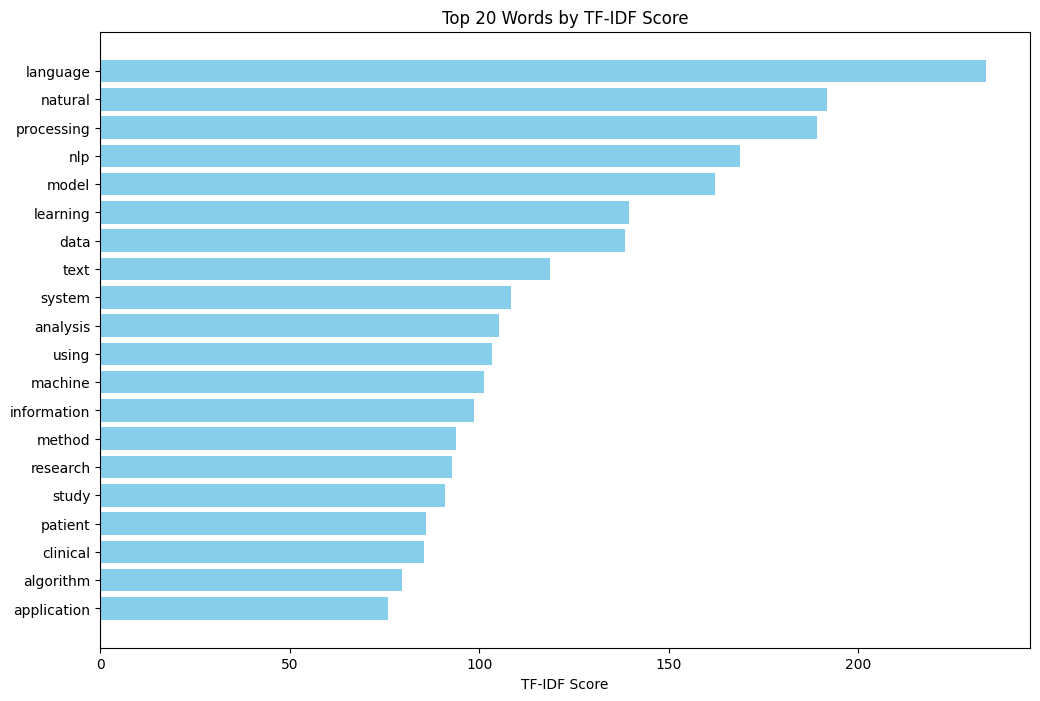

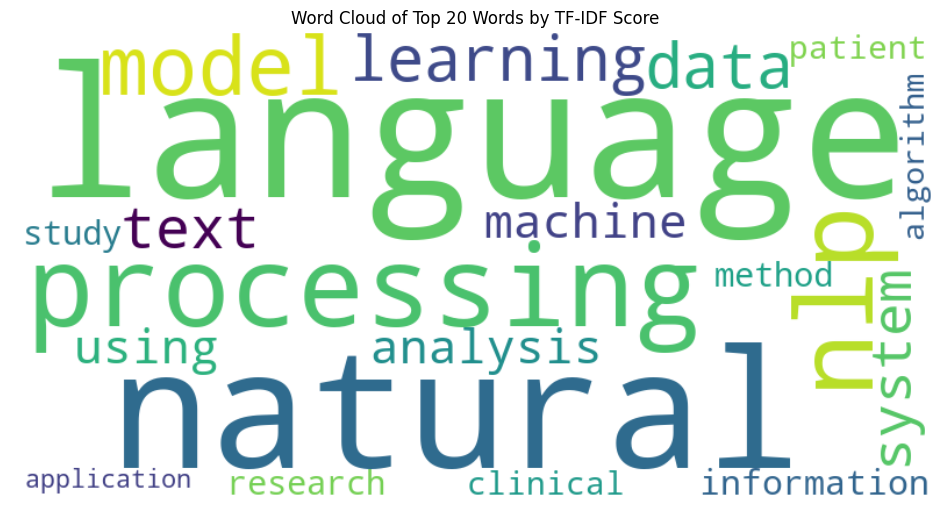

In [7]:
top_words_tfidf = visualize_tfidf('processed_combined_file.csv', 'Processed', top_n=20)

## **word2vec**

Word2Vec is a model that transforms words into continuous numerical vectors, capturing their semantic relationships based on context within a corpus.

We consolidated all the processed data into a single cell and applied Word2Vec to identify the top 20 most common words.

In [8]:
def load_and_preprocess_data(csv_file, column_name):
    df = pd.read_csv(csv_file)
    
    # Load tokenized text data from the specified column
    texts = df[column_name].dropna().tolist()
    # Ensure the data is in list of lists format
    texts = [text if isinstance(text, list) else eval(text) for text in texts]
    
    # Flatten the list of lists into a single list of words
    combined_text = [word for text in texts for word in text]
    
    return combined_text

def train_word2vec(texts, vector_size=100, window=5, min_count=1, workers=4, sg=0):
    # Train a Word2Vec model on the texts
    model = Word2Vec(texts, vector_size=vector_size, window=window, min_count=min_count, workers=workers, sg=sg)
    return model

def visualize_word_importance_word2vec(word_vectors, model, top_n=20):
    # Calculate the mean vector of all word vectors
    mean_vector = np.mean(word_vectors, axis=0)
    scores = {}
    
    # Calculate the dot product of the mean vector with each word vector
    for word in model.wv.index_to_key:
        word_vector = model.wv[word]
        score = np.dot(mean_vector, word_vector)
        scores[word] = score
    
    # Sort words by score and select the top N
    sorted_words = sorted(scores.items(), key=lambda item: item[1], reverse=True)[:top_n]
    words_df = pd.DataFrame(sorted_words, columns=['Word', 'Score'])
    
    # Bar chart of top N words by importance
    plt.figure(figsize=(12, 8))
    plt.barh(words_df['Word'], words_df['Score'], color='skyblue')
    plt.xlabel('Score')
    plt.title(f'Top {top_n} Words by Importance')
    plt.gca().invert_yaxis()
    plt.show()
    
    # Word cloud of top N words by importance
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(sorted_words))
    
    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud of Top {top_n} Words by Importance')
    plt.show()

    important_words = [word for word, _ in sorted_words]
    return important_words

# Example usage
csv_file = 'processed_combined_file.csv' # Replace with your CSV file path
column_name = 'Processed' # Replace with the column name containing the text

# Load and preprocess the data
texts = load_and_preprocess_data(csv_file, column_name)

# Train Word2Vec model
word2vec_model = train_word2vec([texts])  # Pass the list of words as a list of lists



**presenting bar charts and WordCloud For Top 20 Words**

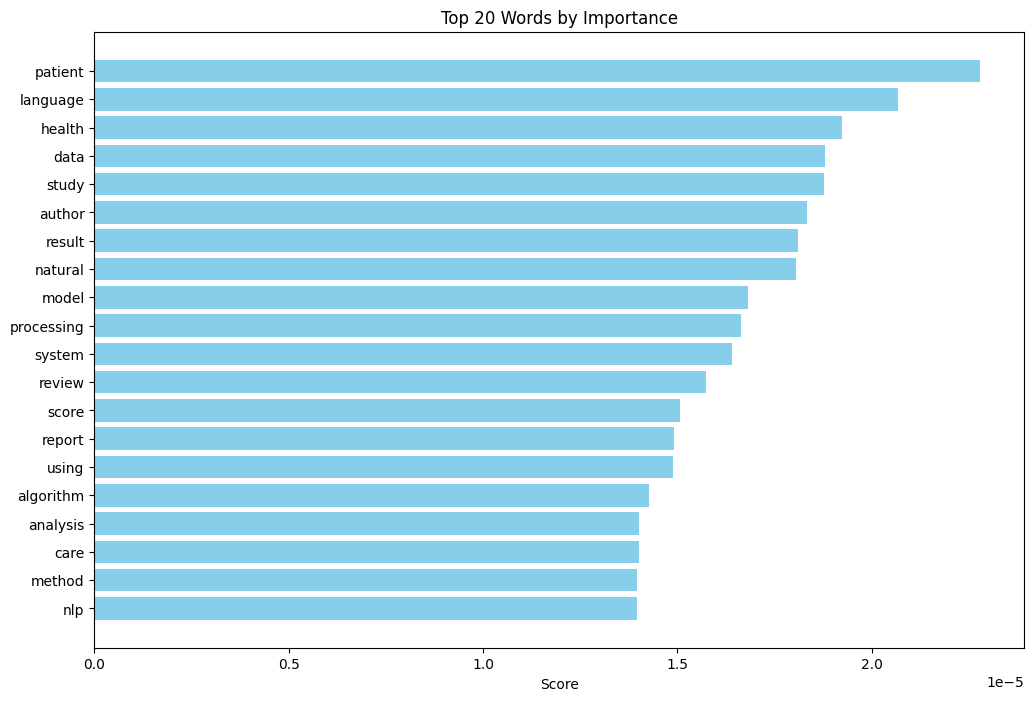

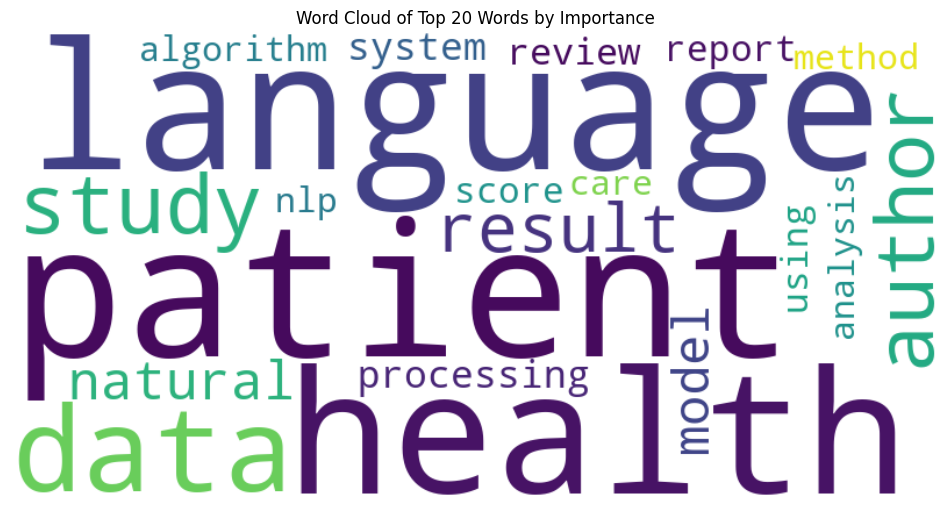

In [9]:
# Visualize the word importance
important_words_word2vec = visualize_word_importance_word2vec(word2vec_model.wv.vectors, word2vec_model, top_n=20)

## **Autoencoder**

An autoencoder is a type of neural network that learns to compress data into a lower-dimensional representation and then reconstruct it, aiming to minimize the difference between the original input and the reconstructed output.

In [10]:
# Step 1: Load and Preprocess Data
def load_and_preprocess_data(csv_file, column_name):
    df = pd.read_csv(csv_file)
    
    # Load tokenized text data from the specified column
    texts = df[column_name].dropna().tolist()
    # Ensure the data is in list of lists format
    texts = [text if isinstance(text, list) else eval(text) for text in texts]
    
    # Flatten the list of lists into a single list of words
    combined_text = [word for text in texts for word in text]
    
    return combined_text

# Step 2: Prepare Data for Autoencoder
def prepare_data_for_autoencoder(texts):
    vocab = list(set(word for text in texts for word in text))
    word_to_index = {word: i for i, word in enumerate(vocab)}
    index_to_word = {i: word for word, i in word_to_index.items()}

    # Convert text to numeric representation
    numeric_texts = [[word_to_index[word] for word in text] for text in texts]

    # Pad sequences
    max_length = max(len(text) for text in numeric_texts)
    padded_texts = tf.keras.preprocessing.sequence.pad_sequences(numeric_texts, maxlen=max_length, padding='post')
    
    return padded_texts, word_to_index, index_to_word, max_length

# Step 3: Build and Train Autoencoder
def build_and_train_autoencoder(padded_texts, input_dim, encoding_dim=32):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(encoding_dim, activation='relu')(input_layer)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)

    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

    autoencoder.fit(padded_texts, padded_texts, epochs=50, batch_size=256, shuffle=True, validation_split=0.2)

    # Get the encoder part of the model
    encoder = Model(input_layer, encoded)
    
    return encoder, autoencoder

# Step 4: Get Important Words from Autoencoder
def get_important_words_autoencoder(encoder, padded_texts, index_to_word, top_n=20):
    # Encode the padded texts
    encoded_texts = encoder.predict(padded_texts)
    
    # Sum the absolute values of the encoded vectors across all text samples
    importance = np.sum(np.abs(encoded_texts), axis=0)
    
    # Get the indices of the top_n highest importance values
    top_indices = importance.argsort()[-top_n:][::-1]
    
    # Convert indices to words using index_to_word
    top_words = [index_to_word[i] for i in top_indices]
    
    return top_words

# Step 1: Load and Preprocess Data
def load_and_preprocess_data(csv_file, column_name):
    df = pd.read_csv(csv_file)
    
    # Load tokenized text data from the specified column
    texts = df[column_name].dropna().tolist()
    # Ensure the data is in list of lists format
    texts = [text if isinstance(text, list) else eval(text) for text in texts]
    return texts

# Step 2: Prepare Data for Autoencoder
def prepare_data_for_autoencoder(texts):
    vocab = list(set(word for text in texts for word in text))
    word_to_index = {word: i for i, word in enumerate(vocab)}
    index_to_word = {i: word for word, i in word_to_index.items()}

    # Convert text to numeric representation
    numeric_texts = [[word_to_index[word] for word in text] for text in texts]

    # Pad sequences
    max_length = max(len(text) for text in numeric_texts)
    padded_texts = tf.keras.preprocessing.sequence.pad_sequences(numeric_texts, maxlen=max_length, padding='post')
    
    return padded_texts, word_to_index, index_to_word, max_length

# Step 3: Build and Train Autoencoder
def build_and_train_autoencoder(padded_texts, input_dim, encoding_dim=32):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(encoding_dim, activation='relu')(input_layer)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)

    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

    autoencoder.fit(padded_texts, padded_texts, epochs=50, batch_size=256, shuffle=True, validation_split=0.2)

    # Get the encoder part of the model
    encoder = Model(input_layer, encoded)
    
    return encoder, autoencoder

# Step 4: Get Important Words from Autoencoder
def get_important_words_autoencoder(encoder, padded_texts, index_to_word, top_n=20):
    # Encode the padded texts
    encoded_texts = encoder.predict(padded_texts)
    
    # Sum the absolute values of the encoded vectors across all text samples
    importance = np.sum(np.abs(encoded_texts), axis=0)
    
    # Get the indices of the top_n highest importance values
    top_indices = importance.argsort()[-top_n:][::-1]
    
    # Convert indices to words using index_to_word
    top_words = [index_to_word[i] for i in top_indices]
    
    # Print the top words
    print("Important Words from Autoencoder:", top_words)
    
    return top_words

# Visualize Word Importance (no scores needed)
def visualize_word_importance(important_words, title="Important Words"):
    # Bar chart
    plt.figure(figsize=(12, 8))
    plt.barh(important_words, range(len(important_words)), color='skyblue')
    plt.xlabel('Importance Rank')
    plt.title(f'{title} by Importance')
    plt.gca().invert_yaxis()
    plt.show()
    
    # Word cloud
    word_frequencies = {word: 1 for word in important_words}  # Equal frequency for all words
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_frequencies)
    
    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud of {title}')
    plt.show()
    return important_words

# Example usage
csv_file = 'processed_combined_file.csv'  # Replace with your CSV file path
column_name = 'Processed'  # Replace with the column name containing the text

# Load and preprocess the data
texts = load_and_preprocess_data(csv_file, column_name)

# Prepare data for autoencoder
padded_texts, word_to_index, index_to_word, max_length = prepare_data_for_autoencoder(texts)

# Train Word2Vec model
if texts:  # Check if texts is not empty
    word2vec_model = Word2Vec([word for text in texts for word in text], 
                              vector_size=100, window=5, min_count=1, workers=4, sg=0)
else:
    raise ValueError("No text data available to train Word2Vec model.")

# Build and train the autoencoder
encoder, autoencoder = build_and_train_autoencoder(padded_texts, input_dim=max_length)

# Get important words from autoencoder
important_words_autoencoder = get_important_words_autoencoder(encoder, padded_texts, index_to_word, top_n=20)




Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: -15204809.0000 - val_loss: -96513888.0000
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -198168128.0000 - val_loss: -467240096.0000
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -748725312.0000 - val_loss: -1257185408.0000
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -1843641728.0000 - val_loss: -2553041664.0000
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -3531643392.0000 - val_loss: -4415353344.0000
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -5941778944.0000 - val_loss: -6881713152.0000
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -9127146496.0000 - val_loss: -9966130176.0000
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -13089428480.0000 - val_loss: -13672520704.0000
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: -17544470528.0000 - val_loss: -18018088960.0000
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: -226968

We trained an autoencoder model then used it to identify the 20 most important words and displayed them using a WordCloud and a bar chart.

Important Words from Autoencoder: ['gleaned', 'puttini', 'conclusion', 'inaccessibility', 'nipp', 'paglialonga', 'biçen', 'cnil', 'radiation', 'francopoulo', 'kuldeep', 'emotweet', 'belhadef', 'agirre', 'edf', 'fashioned', 'ingested', 'lsdd', 'geriatric', 'koçak']


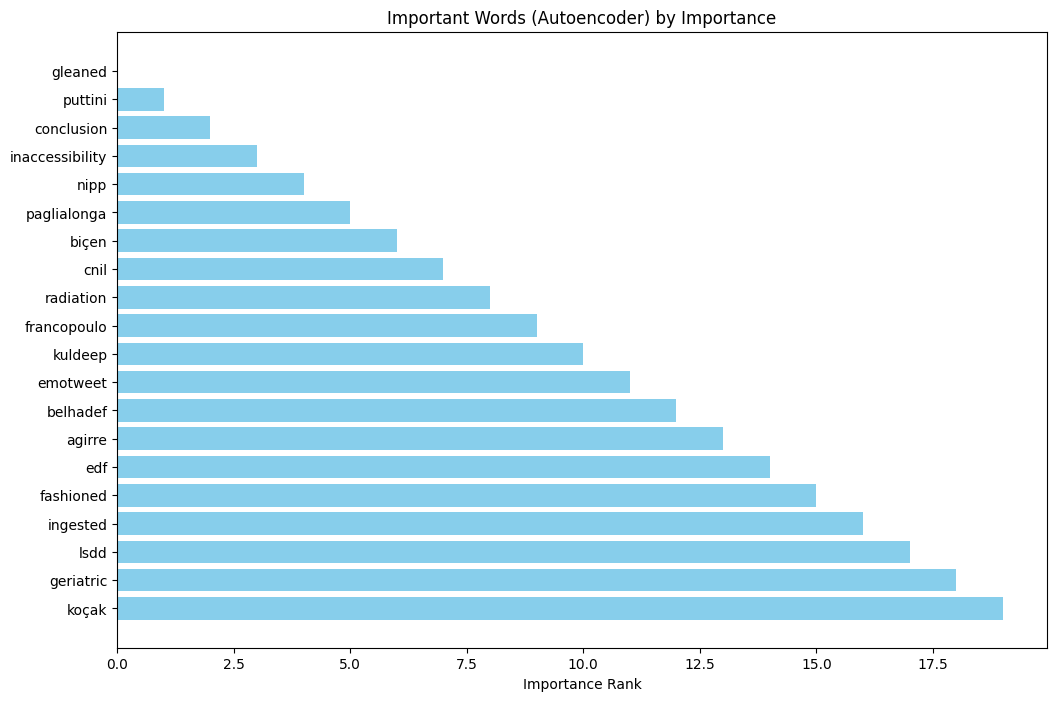

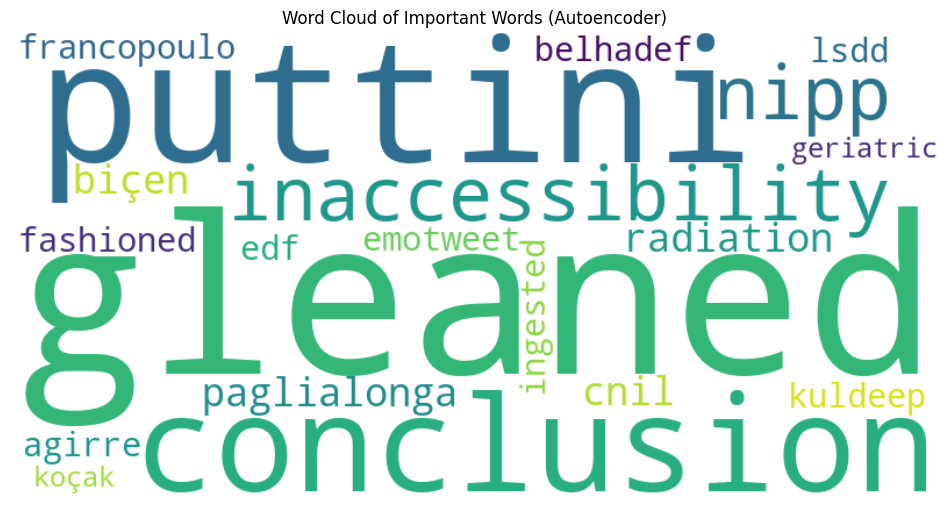

In [11]:
# Visualize the important words
print("Important Words from Autoencoder:", important_words_autoencoder)
important_words_autoencoder = visualize_word_importance(important_words_autoencoder, title="Important Words (Autoencoder)")


## **Comparing Data**

We used a Venn diagram to visualize the overlap between the top important words identified by TF-IDF, Word2Vec, and the autoencoder.

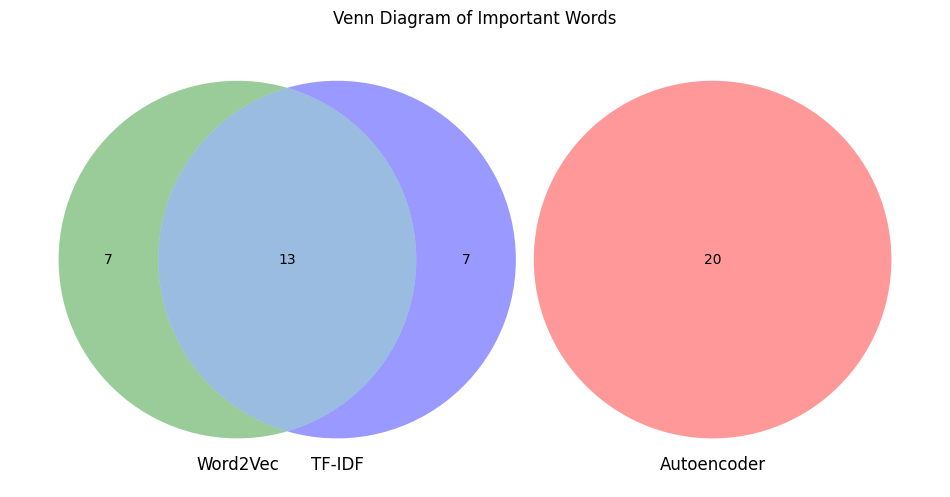

In [12]:
# Convert to sets for comparison
set_autoencoder = set(important_words_autoencoder)
set_word2vec = set(important_words_word2vec)
set_tfidf = set(top_words_tfidf)

# Venn Diagram
plt.figure(figsize=(12, 8))
venn3([set_autoencoder, set_word2vec, set_tfidf], 
      ('Autoencoder', 'Word2Vec', 'TF-IDF'))
plt.title("Venn Diagram of Important Words")
plt.show()

# Create a DataFrame for bar chart comparison
all_words = list(set_autoencoder | set_word2vec | set_tfidf)  # Union of all sets

comparison_df = pd.DataFrame({
    'Word': all_words,
    'Autoencoder': [1 if word in set_autoencoder else 0 for word in all_words],
    'Word2Vec': [1 if word in set_word2vec else 0 for word in all_words],
    'TF-IDF': [1 if word in set_tfidf else 0 for word in all_words]
})
plt.show()

In [13]:
print("Important words from Autoencoder:", important_words_autoencoder)
print("Important words from Word2Vec:", important_words_word2vec)
print("Top words from TF-IDF:", top_words_tfidf)

Important words from Autoencoder: ['gleaned', 'puttini', 'conclusion', 'inaccessibility', 'nipp', 'paglialonga', 'biçen', 'cnil', 'radiation', 'francopoulo', 'kuldeep', 'emotweet', 'belhadef', 'agirre', 'edf', 'fashioned', 'ingested', 'lsdd', 'geriatric', 'koçak']
Important words from Word2Vec: ['patient', 'language', 'health', 'data', 'study', 'author', 'result', 'natural', 'model', 'processing', 'system', 'review', 'score', 'report', 'using', 'algorithm', 'analysis', 'care', 'method', 'nlp']
Top words from TF-IDF: ['language', 'natural', 'processing', 'nlp', 'model', 'learning', 'data', 'text', 'system', 'analysis', 'using', 'machine', 'information', 'method', 'research', 'study', 'patient', 'clinical', 'algorithm', 'application']


## **NER**

**Named Entity Recognition (NER) is a process in natural language processing (NLP) that identifies and classifies entities within a text.**

**We combined all the text and applied an algorithm to identify Named Entities (NER).** 

**We then summarized the results by counting the occurrences of each entity type, visualized these counts using a bar chart, and created a word cloud to display the most frequent named entities.**

In [14]:
combined_text = ' '.join(df_combined[df_combined.columns[0]].dropna().astype(str))

In [15]:
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('maxent_ne_chunker')
nltk.download('words')

# Tokenize the combined text
tokens = word_tokenize(combined_text)

# Tag tokens with parts of speech
tagged_tokens = pos_tag(tokens)

# Perform Named Entity Recognition
named_entities = ne_chunk(tagged_tokens)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\97250.ADIRB\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\97250.ADIRB\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\97250.ADIRB\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\97250.ADIRB\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [16]:
from collections import Counter

# Count the named entities by label
entity_counts = Counter(subtree.label() for subtree in named_entities if hasattr(subtree, 'label'))

# Print summary
for label, count in entity_counts.items():
    print(f"Entity Type: {label}, Count: {count}")

Entity Type: ORGANIZATION, Count: 45763
Entity Type: PERSON, Count: 34300
Entity Type: GPE, Count: 12356
Entity Type: FACILITY, Count: 57
Entity Type: GSP, Count: 131
Entity Type: LOCATION, Count: 82


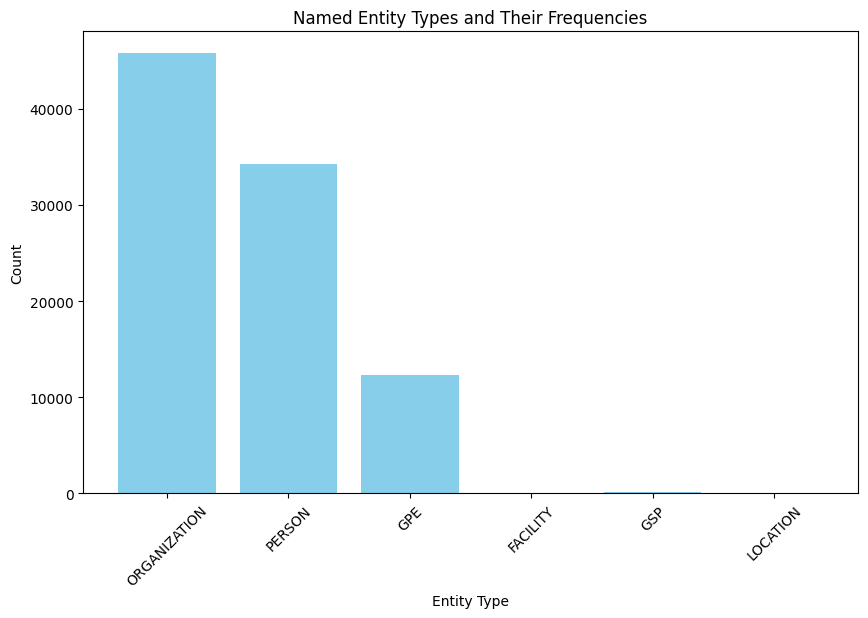

In [17]:
import matplotlib.pyplot as plt

# Extract labels and counts
labels, counts = zip(*entity_counts.items())

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color='skyblue')
plt.xlabel('Entity Type')
plt.ylabel('Count')
plt.title('Named Entity Types and Their Frequencies')
plt.xticks(rotation=45)
plt.show()

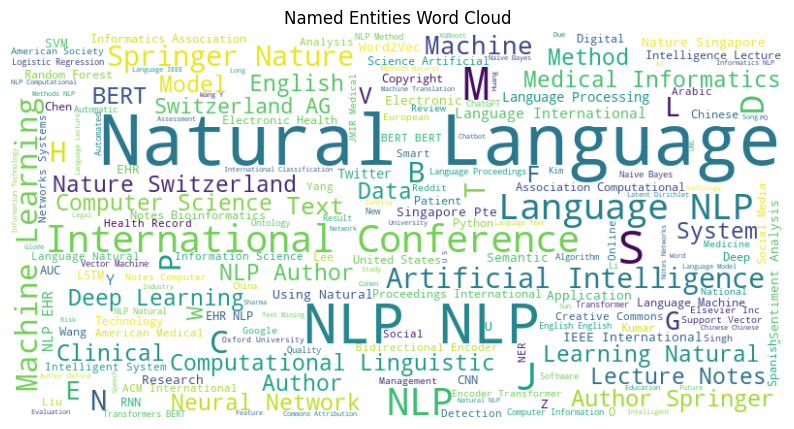

In [18]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Extract entity names from named entities
entity_names = [ ' '.join(c[0] for c in subtree) for subtree in named_entities if hasattr(subtree, 'label')]

# Join all entity names into a single string
entity_text = ' '.join(entity_names)

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(entity_text)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Named Entities Word Cloud')
plt.show()

# **Exploratory Data Analysis**

**number of articles published each year and the top authors by number of publications**

In [19]:
# EDA: Number of articles published each year
articles_per_year = df['Year'].value_counts().sort_index()

# EDA: Top authors by number of publications
# Splitting authors by ';' and counting occurrences
authors_series = df['Authors'].dropna().str.split(';').explode().str.strip()
top_authors = authors_series.value_counts().head(10)

# Display the results
print("Number of articles published each year:")
print(articles_per_year)

print("\nTop 10 authors by number of publications:")
print(top_authors)

Number of articles published each year:
Year
2017      79
2018     251
2019     404
2020     556
2021     788
2022     983
2023    1235
2024     703
2025       1
Name: count, dtype: int64

Top 10 authors by number of publications:
Authors
Wang Y.     51
Li Y.       44
Zhang Y.    42
Liu H.      40
Liu Y.      32
Li J.       27
Wang L.     26
Wang X.     25
Fu S.       25
Zhang Z.    24
Name: count, dtype: int64


**Most Popular Journals/Conferences**

Find out which journals or conferences are the most frequent sources for publications.

In [20]:
# EDA: Most popular journals/conferences
top_journals = df['Source title'].value_counts().head(10)

print("Top 10 most popular journals/conferences:")
print(top_journals)

Top 10 most popular journals/conferences:
Source title
Lecture Notes in Computer Science (including subseries Lecture Notes in Artificial Intelligence and Lecture Notes in Bioinformatics)    97
CEUR Workshop Proceedings                                                                                                               86
Lecture Notes in Networks and Systems                                                                                                   83
ACM International Conference Proceeding Series                                                                                          79
Communications in Computer and Information Science                                                                                      60
JMIR Medical Informatics                                                                                                                59
IEEE Access                                                                                                    

**Most Common Keywords**

Find out which journals or conferences are the most frequent sources for publications.

In [21]:
# EDA: Most common keywords
keywords_series = df['Author Keywords'].dropna().str.split(';').explode().str.strip()
top_keywords = keywords_series.value_counts().head(10)

print("Top 10 most common keywords:")
print(top_keywords)

Top 10 most common keywords:
Author Keywords
Natural language processing    1106
natural language processing     873
Natural Language Processing     595
NLP                             352
Machine learning                350
machine learning                275
Machine Learning                180
Deep learning                   164
Artificial intelligence         157
artificial intelligence         119
Name: count, dtype: int64


**Articles Distribution Over Time**

Visualize the number of articles published each year to observe trends over time.

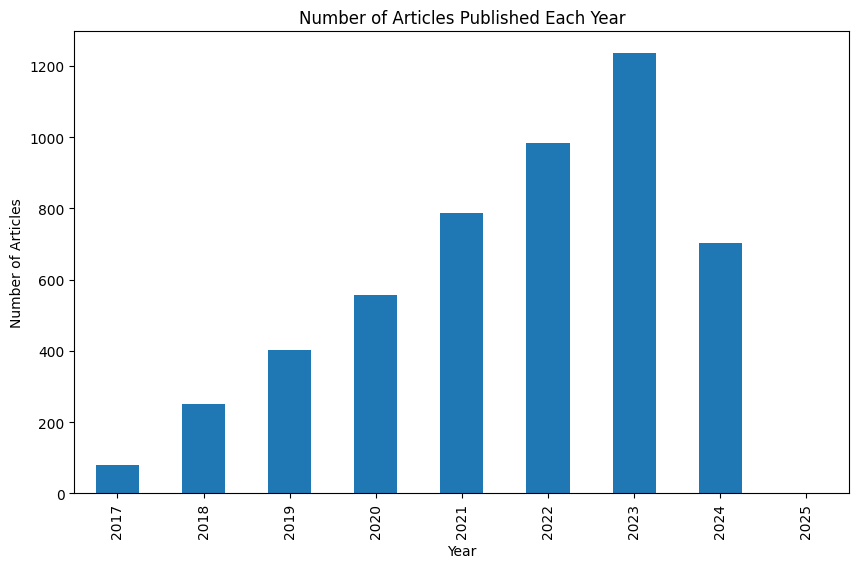

In [22]:
import matplotlib.pyplot as plt

# Plotting the number of articles published each year
articles_per_year.plot(kind='bar', figsize=(10,6))
plt.title("Number of Articles Published Each Year")
plt.xlabel("Year")
plt.ylabel("Number of Articles")
plt.show()

**Number of Authors per Article**

Examine how many authors are contributing to each article. This can give insights into collaboration trends.

In [23]:
# EDA: Number of authors per article
df['Num Authors'] = df['Authors'].apply(lambda x: len(x.split(';')) if pd.notna(x) else 0)
authors_per_article = df['Num Authors'].value_counts().sort_index()

print("Number of authors per article distribution:")
print(authors_per_article)

Number of authors per article distribution:
Num Authors
0      68
1     350
2     811
3     954
4     768
5     575
6     531
7     260
8     205
9     122
10     93
11     63
12     53
13     38
14     28
15     16
16     10
17      8
18      7
19      5
20      7
21      8
22      6
23      2
24      1
25      2
26      1
28      2
29      1
32      1
34      1
39      1
42      1
60      1
Name: count, dtype: int64


**Word Count of Abstracts**

Analyze the length of abstracts by calculating the word count and observing the distribution.

In [24]:
# EDA: Word count of abstracts
df['Abstract Word Count'] = df['Abstract'].apply(lambda x: len(x.split()))
abstract_word_count = df['Abstract Word Count'].describe()

print("Abstract word count statistics:")
print(abstract_word_count)

Abstract word count statistics:
count    5000.000000
mean      201.039600
std        85.337706
min         3.000000
25%       145.000000
50%       192.000000
75%       251.000000
max       599.000000
Name: Abstract Word Count, dtype: float64


**Top Authors Publishing Trends**

Analyze how the top authors' publication output has changed over the years.

In [25]:
# EDA: Top authors' publishing trends over the years
top_authors_list = top_authors.index.tolist()
df_top_authors = df[df['Authors'].apply(lambda x: any(author in x for author in top_authors_list) if pd.notna(x) else False)]

authors_yearly_trends = df_top_authors.groupby('Year')['Authors'].apply(lambda x: ';'.join(x).split(';')).apply(pd.Series.value_counts).fillna(0)

print("Top authors' publishing trends over the years:")
print(authors_yearly_trends)

Top authors' publishing trends over the years:
      Wi C.-I.   Zhang C.   Li Q.   Mu X.   Zheng H.   Wang D.  Zhang D.Y.  \
Year                                                                         
2017       1.0        1.0     1.0     1.0        1.0       1.0         1.0   
2018       1.0        0.0     0.0     0.0        0.0       0.0         0.0   
2019       0.0        0.0     0.0     0.0        0.0       0.0         0.0   
2020       0.0        2.0     0.0     0.0        0.0       1.0         0.0   
2021       0.0        2.0     0.0     0.0        0.0       0.0         0.0   
2022       0.0        1.0     1.0     0.0        0.0       0.0         0.0   
2023       0.0        0.0     0.0     0.0        0.0       0.0         0.0   
2024       0.0        2.0     0.0     0.0        0.0       0.0         0.0   

       Zhu Y.   Yang H.   Han Q.  ...   Zheng M.  Gao X.   Guan W.  Sun W.  \
Year                              ...                                        
2017      1.0   

C:\Users\97250.ADIRB\AppData\Local\Temp\ipykernel_1292\1195876784.py:5: FutureWarning: value_counts with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  authors_yearly_trends = df_top_authors.groupby('Year')['Authors'].apply(lambda x: ';'.join(x).split(';')).apply(pd.Series.value_counts).fillna(0)
C:\Users\97250.ADIRB\AppData\Local\Temp\ipykernel_1292\1195876784.py:5: FutureWarning: value_counts with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  authors_yearly_trends = df_top_authors.groupby('Year')['Authors'].apply(lambda x: ';'.join(x).split(';')).apply(pd.Series.value_counts).fillna(0)
C:\Users\97250.ADIRB\AppData\Local\Temp\ipykernel_1292\1195876784.py:5: FutureWarning: value_counts with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  authors_yearly_trends

**Correlation Between Keywords and Publication Year**

Explore if certain keywords are associated more with publications in specific years

In [26]:
# EDA: Correlation between keywords and publication year
keywords_per_year = df.groupby('Year')['Author Keywords'].apply(lambda x: ';'.join(x.dropna()).split(';')).explode().str.strip().value_counts()

print("Keywords per year distribution:")
print(keywords_per_year)

Keywords per year distribution:
Author Keywords
Natural language processing                      1106
natural language processing                       873
Natural Language Processing                       595
NLP                                               352
Machine learning                                  350
                                                 ... 
suicide attempt                                     1
Telegram API                                        1
process safety management system                    1
E-invoicing process                                 1
Term frequency and inverse document frequency       1
Name: count, Length: 10331, dtype: int64


# **visualize EDA**

C:\Users\97250.ADIRB\AppData\Local\Temp\ipykernel_1292\1432505014.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=articles_per_year.index, y=articles_per_year.values, palette="Blues_d")


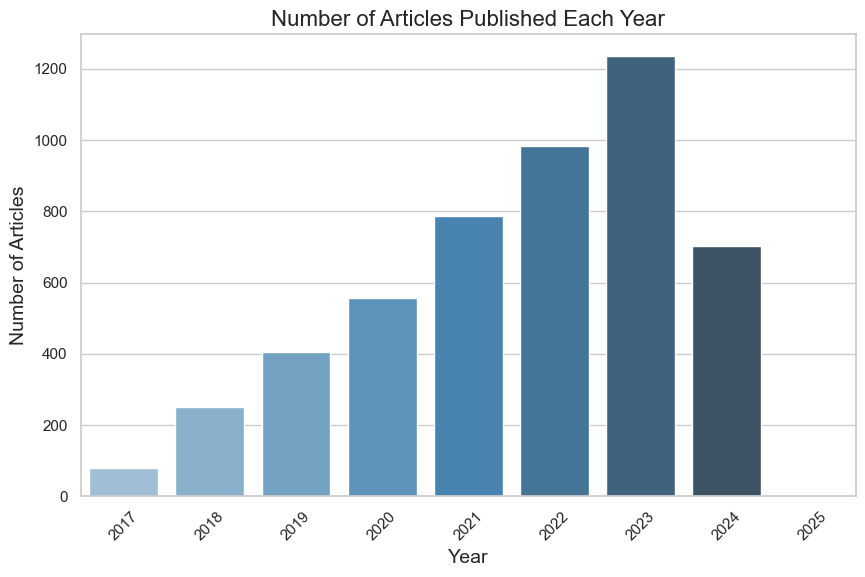

C:\Users\97250.ADIRB\AppData\Local\Temp\ipykernel_1292\1432505014.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_authors.values, y=top_authors.index, palette="Greens_d")


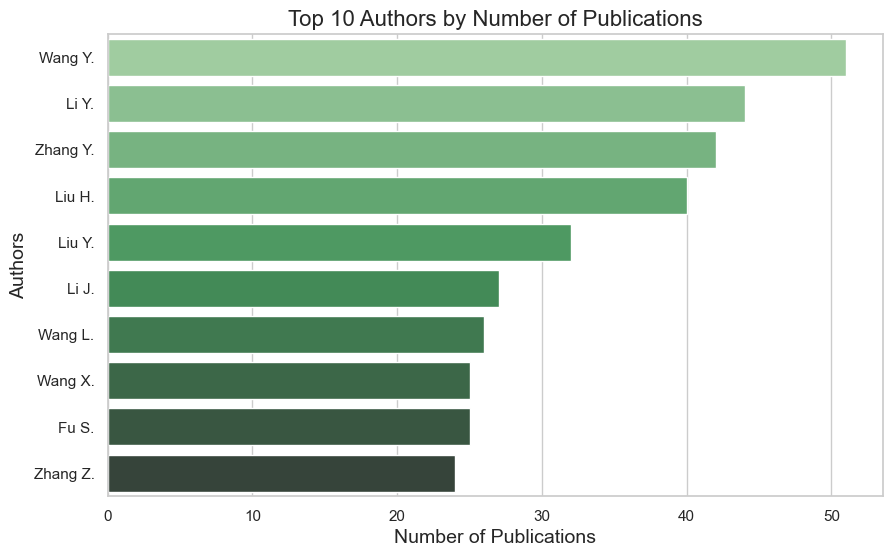

C:\Users\97250.ADIRB\AppData\Local\Temp\ipykernel_1292\1432505014.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_journals.values, y=top_journals.index, palette="Oranges_d")


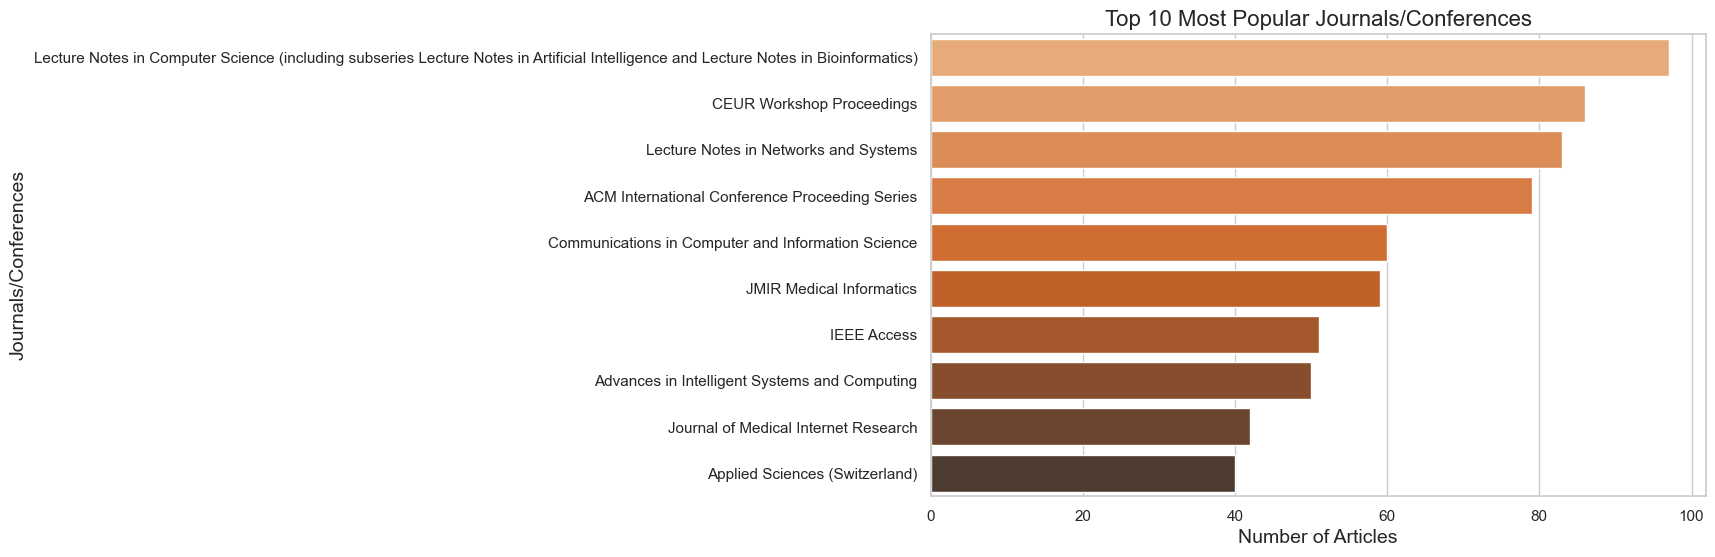

C:\Users\97250.ADIRB\AppData\Local\Temp\ipykernel_1292\1432505014.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=authors_per_article.index, y=authors_per_article.values, palette="Purples_d")


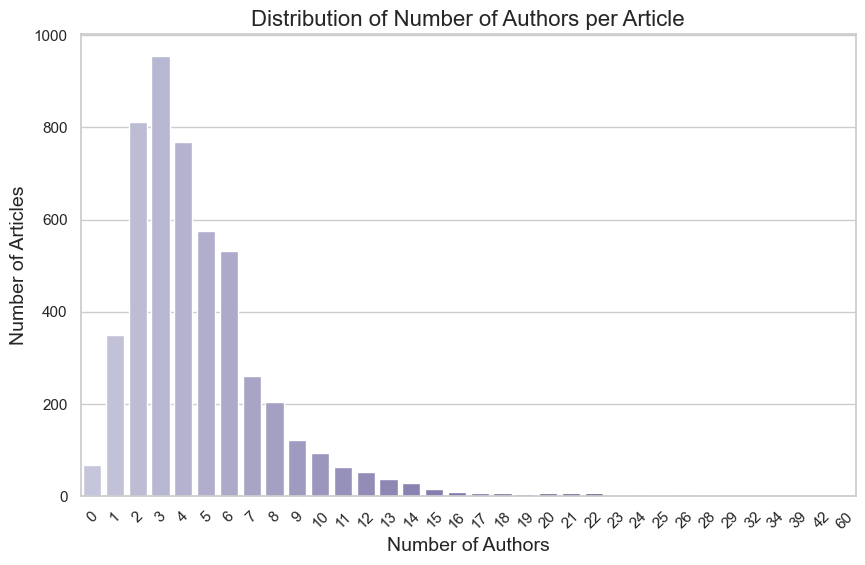

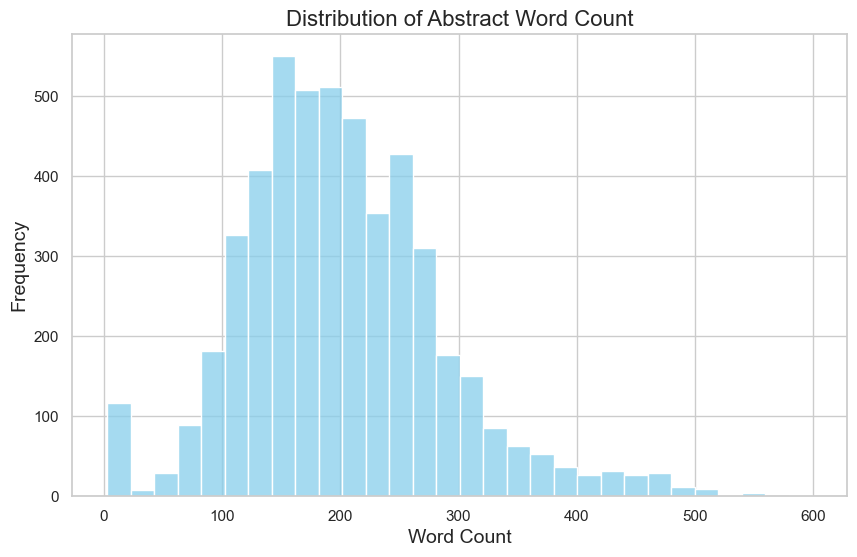

In [27]:
# Set seaborn style for prettier plots
sns.set(style="whitegrid")

# Plot 1: Number of Articles Published Each Year
plt.figure(figsize=(10, 6))
sns.barplot(x=articles_per_year.index, y=articles_per_year.values, palette="Blues_d")
plt.title("Number of Articles Published Each Year", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Number of Articles", fontsize=14)
plt.xticks(rotation=45)
plt.show()

# Plot 2: Top 10 Authors by Number of Publications
plt.figure(figsize=(10, 6))
sns.barplot(x=top_authors.values, y=top_authors.index, palette="Greens_d")
plt.title("Top 10 Authors by Number of Publications", fontsize=16)
plt.xlabel("Number of Publications", fontsize=14)
plt.ylabel("Authors", fontsize=14)
plt.show()

# Plot 3: Top 10 Most Popular Journals/Conferences
top_journals = df['Source title'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_journals.values, y=top_journals.index, palette="Oranges_d")
plt.title("Top 10 Most Popular Journals/Conferences", fontsize=16)
plt.xlabel("Number of Articles", fontsize=14)
plt.ylabel("Journals/Conferences", fontsize=14)
plt.show()

# Plot 4: Number of Authors per Article
plt.figure(figsize=(10, 6))
sns.barplot(x=authors_per_article.index, y=authors_per_article.values, palette="Purples_d")
plt.title("Distribution of Number of Authors per Article", fontsize=16)
plt.xlabel("Number of Authors", fontsize=14)
plt.ylabel("Number of Articles", fontsize=14)
plt.xticks(rotation=45)
plt.show()

# Plot 5: Abstract Word Count Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Abstract Word Count'], bins=30, kde=False, color='skyblue')
plt.title("Distribution of Abstract Word Count", fontsize=16)
plt.xlabel("Word Count", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.show()

**NLP-Specific EDA**

Top NLP Topics by Keywords:

Analyze the most common keywords to understand the primary research areas in the dataset.
Evolution of NLP Research:

Track the changes in popular keywords over time to see how the focus of research has shifted.
Top NLP Techniques/Models:

Identify the most frequently mentioned techniques or models (e.g., BERT, GPT) from the keywords or abstracts.

C:\Users\97250.ADIRB\AppData\Local\Temp\ipykernel_1292\2639705190.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_keywords.values, y=top_keywords.index, palette="coolwarm")


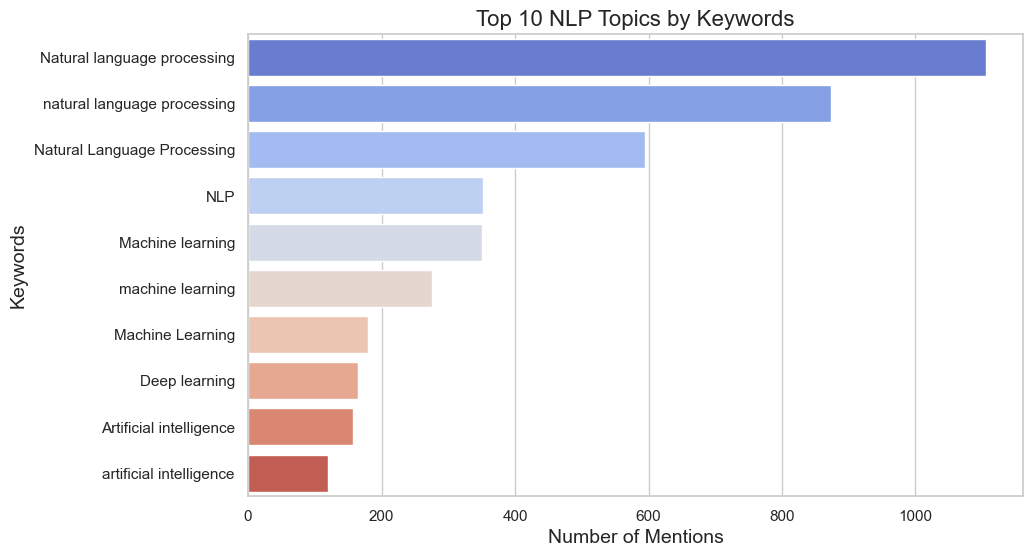

C:\Users\97250.ADIRB\AppData\Local\Temp\ipykernel_1292\2639705190.py:21: FutureWarning: value_counts with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  keywords_over_time = df_keywords_year.groupby('Year')['Author Keywords'].apply(lambda x: ';'.join(x).split(';')).apply(pd.Series.value_counts).fillna(0)
C:\Users\97250.ADIRB\AppData\Local\Temp\ipykernel_1292\2639705190.py:21: FutureWarning: value_counts with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  keywords_over_time = df_keywords_year.groupby('Year')['Author Keywords'].apply(lambda x: ';'.join(x).split(';')).apply(pd.Series.value_counts).fillna(0)
C:\Users\97250.ADIRB\AppData\Local\Temp\ipykernel_1292\2639705190.py:21: FutureWarning: value_counts with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  keyw

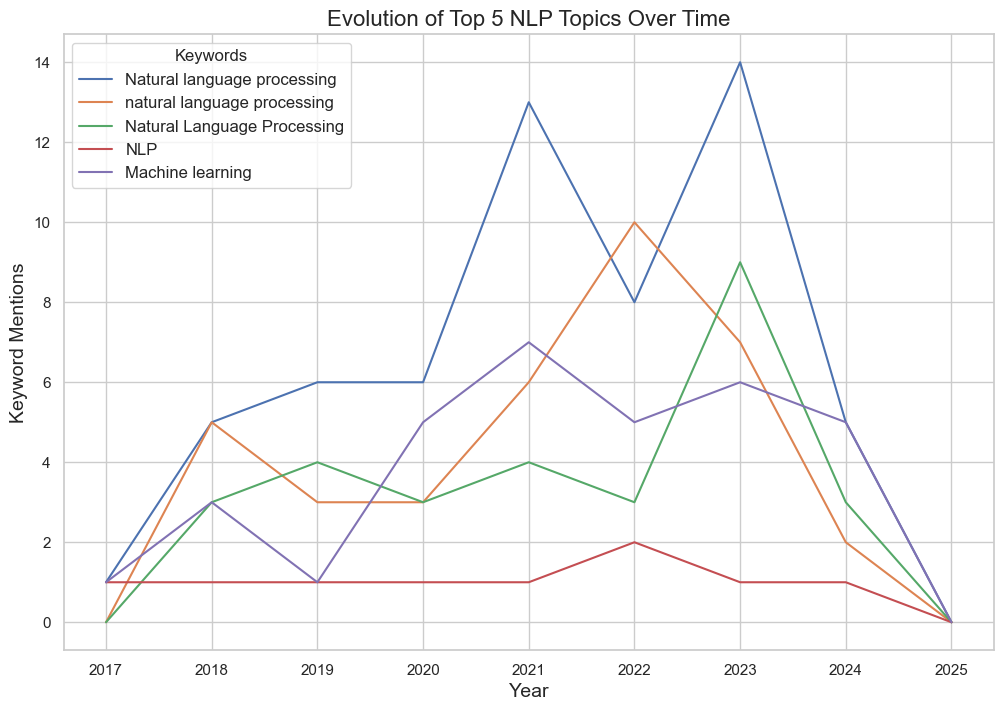

C:\Users\97250.ADIRB\AppData\Local\Temp\ipykernel_1292\2639705190.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_mentions_series.values, y=model_mentions_series.index, palette="Blues_d")


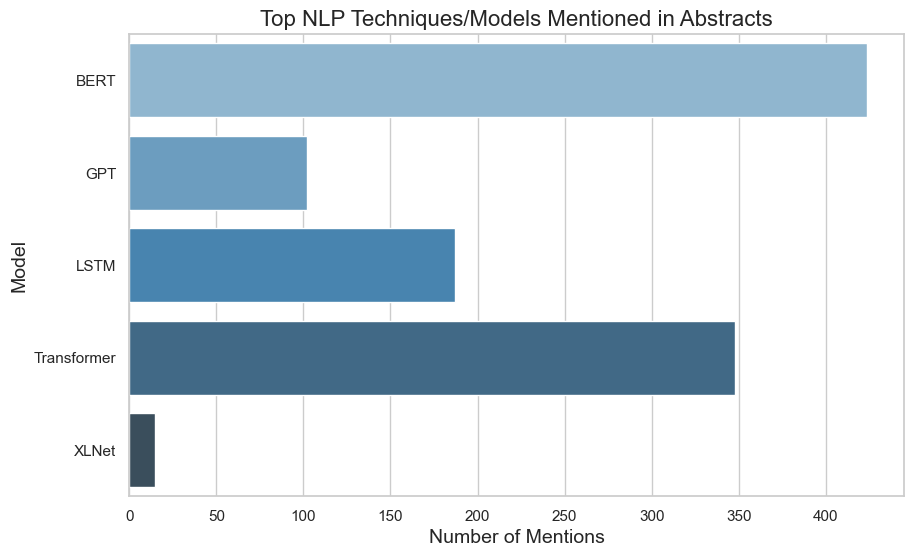

In [28]:
import matplotlib.pyplot as plt
from collections import Counter

# Set seaborn style
sns.set(style="whitegrid")

# Preprocess keywords for analysis
keywords_series = df['Author Keywords'].dropna().str.split(';').explode().str.strip()

# Plot 1: Top 10 NLP topics by keywords
top_keywords = keywords_series.value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_keywords.values, y=top_keywords.index, palette="coolwarm")
plt.title("Top 10 NLP Topics by Keywords", fontsize=16)
plt.xlabel("Number of Mentions", fontsize=14)
plt.ylabel("Keywords", fontsize=14)
plt.show()

# Plot 2: Evolution of NLP topics over time (using top 5 keywords)
df_keywords_year = df.dropna(subset=['Author Keywords', 'Year'])
keywords_over_time = df_keywords_year.groupby('Year')['Author Keywords'].apply(lambda x: ';'.join(x).split(';')).apply(pd.Series.value_counts).fillna(0)
top_5_keywords = keywords_series.value_counts().head(5).index.tolist()

# Plot evolution of top 5 keywords over time
plt.figure(figsize=(12, 8))
for keyword in top_5_keywords:
    sns.lineplot(data=keywords_over_time[keyword], label=keyword)

plt.title("Evolution of Top 5 NLP Topics Over Time", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Keyword Mentions", fontsize=14)
plt.legend(title="Keywords", fontsize=12)
plt.show()

# Plot 3: Top NLP techniques/models (mentioning common NLP models in abstracts)
nlp_models = ['BERT', 'GPT', 'LSTM', 'Transformer', 'XLNet']
df['Abstract'] = df['Abstract'].fillna('')

# Count model mentions in abstracts
model_mentions = {model: df['Abstract'].str.contains(model, case=False).sum() for model in nlp_models}
model_mentions_series = pd.Series(model_mentions)

# Plot the top NLP techniques/models
plt.figure(figsize=(10, 6))
sns.barplot(x=model_mentions_series.values, y=model_mentions_series.index, palette="Blues_d")
plt.title("Top NLP Techniques/Models Mentioned in Abstracts", fontsize=16)
plt.xlabel("Number of Mentions", fontsize=14)
plt.ylabel("Model", fontsize=14)
plt.show()

## **Most Common Words**

We identified the most common words and, for each one, analyzed its trend over the past 10 years.

In [29]:
df = pd.read_csv('scopus.csv')

# Combine all abstracts into a single string
combined_text = ' '.join(df['Abstract'].dropna())

def tfidf_most_common_words(text, num_words=10):
    vectorizer = TfidfVectorizer(stop_words='english', token_pattern=r'(?u)\b\w+\b')
    tfidf_matrix = vectorizer.fit_transform([text])
    feature_names = vectorizer.get_feature_names_out()
    scores = tfidf_matrix.toarray()[0]
    word_scores = list(zip(feature_names, scores))
    word_scores = [(word, score) for word, score in word_scores if not word.isdigit()]
    sorted_word_scores = sorted(word_scores, key=lambda x: x[1], reverse=True)
    return sorted_word_scores[:num_words]

# Extract the top common words
tfidf_common_words = tfidf_most_common_words(combined_text, num_words=10)
tfidf_common_words = [word for word, score in tfidf_common_words]

print("tfidf_common_words:", tfidf_common_words)

# Function to clean and tokenize text
def tokenize(text):
    text = re.sub(r'[^\w\s]', '', text.lower())  # Remove punctuation and lowercase
    return text.split()

# Initialize dictionary to store word counts by year
word_count_by_year = {word: Counter() for word in tfidf_common_words}

# Count occurrences of common words by year
for index, row in df.iterrows():
    year = row['Year']
    words = tokenize(row['Abstract'])
    
    for word in tfidf_common_words:
        word_count_by_year[word][year] += words.count(word.lower())

# Create a DataFrame for plotting
count_data = {word: [] for word in tfidf_common_words}
years = sorted(df['Year'].unique())

for year in years:
    for word in tfidf_common_words:
        count_data[word].append(word_count_by_year[word][year])

count_df = pd.DataFrame(count_data, index=years)

tfidf_common_words: ['nlp', 'language', 'data', 'processing', 'natural', 'based', 'using', 'text', 'model', 'learning']


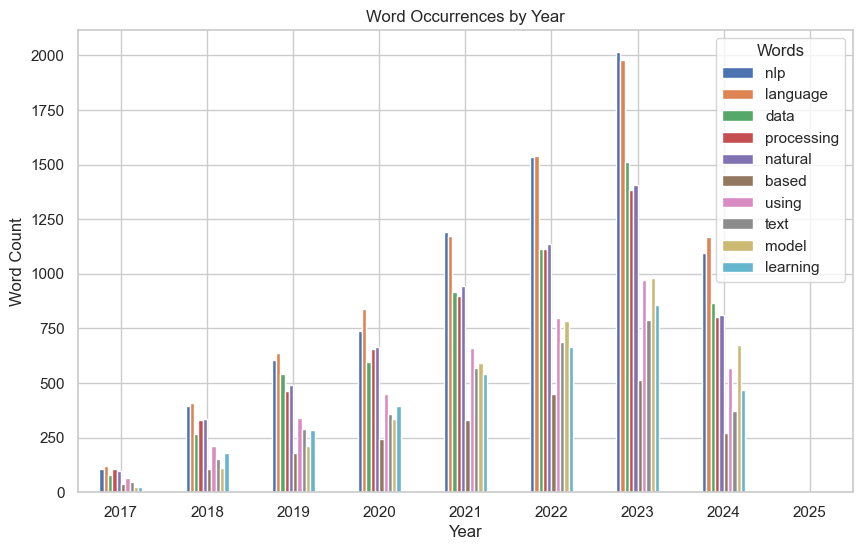

In [30]:
# Plot the word counts by year
count_df.plot(kind='bar', figsize=(10, 6))
plt.title('Word Occurrences by Year')
plt.xlabel('Year')
plt.ylabel('Word Count')
plt.xticks(rotation=0)
plt.legend(title="Words")
plt.show()

# **Summarization**

We summarized 9 abstracts (processing took longer than expected) and presented the summaries of these abstracts.

In [31]:
# Load the summarization pipeline
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

In [32]:
# Apply summarization
def summarize_text(text):
    # Summarize the text and return the summary
    summary = summarizer(text, max_length=150, min_length=30, do_sample=False)
    return summary[0]['summary_text']

In [33]:
# Add a new column with the summaries
df = pd.read_csv('scopus2.csv')
df_Summary = df['Abstract'].apply(summarize_text)

print(df_Summary)

Your max_length is set to 150, but your input_length is only 7. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3)


0    Study explored potential of using natural lang...
1    The development of natural language processing...
2    Heart failure with preserved ejection fraction...
3    Study aimed to develop and validate a natural ...
4    Socioeconomic status (SES) provides a framewor...
5    The study was published in the Journal of the ...
6    The decoding of the human genome, completed tw...
7    The construction industry is marred by a high ...
8    Proposed method is distinguished by the use of...
Name: Abstract, dtype: object


## **QUESTION ANSWERING**

In [34]:
# Load the question-answering pipeline with the specified model
generator = pipeline("question-answering", model="distilbert-base-cased-distilled-squad", tokenizer="distilbert-base-cased-distilled-squad")

# Combined text string containing all the abstracts
combined_text = " ".join(df['Abstract'].tolist())

def shorten_text(text, word_limit=500):
    words = text.split()
    if len(words) > word_limit:
        shortened = " ".join(words[:word_limit])
        return shortened
    return text

# Example usage
shortened_text = shorten_text(combined_text, word_limit=20000)

# Define function to extract topics from combined text
def extract_topics(abstract):
    prompt = "What are the main topics of this text?"
    result = generator(question=prompt, context=abstract)
    return result['answer']

# Apply the function directly to the combined_text
df_Topics = extract_topics(shortened_text)



**GPT2 model to identify the most common topics using QUESTION ANSWERING**

In [35]:
print("Extracted Topics:", df_Topics)

Extracted Topics: natural language texts


# **Comparing Extracted Topics with Common Words from TF-IDF**

Comparing the two, the "Extracted Topics" offer a high-level view of the thematic content, while the "TF-IDF Common Words" provide a more detailed analysis of specific terms that frequently contribute to those themes. In this case, the common words align closely with the extracted topic of "natural language texts," indicating that the dataset predominantly focuses on key aspects of NLP, such as data processing, modeling, and learning. The frequent appearance of terms like 'NLP,' 'language,' 'data,' and 'processing' in the TF-IDF list underscores the emphasis on NLP, suggesting that the texts often cover these core concepts.

Overall, while "Extracted Topics" give a broad thematic perspective, "TF-IDF Common Words" offer a granular look at significant terms within those themes. Together, they provide a comprehensive understanding of the text data, from overarching subjects to critical keywords.

# **Review**

We began by manually exporting 5,000 articles from the Scopus website, capturing the Authors, Title, Year, Source Title, Abstract, and Author Keywords for each article. This data was saved in the scopus.csv file.

Next, we performed data preparation and preprocessing, focusing on tokenization, lemmatization, and stop word removal. To facilitate this, we combined all columns into a single text field for each of the 5,000 articles.

After preprocessing, we applied TF-IDF to the data and visualized the top 20 most common words using bar charts and word clouds. We then used Word2Vec to identify the top 20 words, which were similarly visualized.

We also trained an autoencoder model to identify the 20 most important words, displaying them through word clouds and bar charts. We compared the results using a Venn diagram, which revealed significant overlap between the words identified by TF-IDF and Word2Vec, while the autoencoder results showed some differences.

Next, we applied Named Entity Recognition (NER) to the combined text, summarizing the results by counting the occurrences of each entity type. These counts were visualized using bar charts and word clouds.

Exploratory Data Analysis (EDA):


We conducted an exploratory data analysis to gain further insights, focusing on:


Article Publication Trends: The number of articles published each year.


Top Authors: Authors with the highest number of publications.


Most Popular Journals/Conferences: The frequency of publications across different sources.


Keyword Analysis: Identification of common keywords and their evolution over time.


Author Collaboration Trends: Examination of the number of authors contributing to each article.


Abstract Word Count Distribution: Analysis of the length of abstracts.


Top Authors' Publishing Trends: Changes in publication output over the years for top authors.


Correlation Between Keywords and Publication Year: Exploration of the relationship between keywords and their associated publication years.


Visualizations included:


Number of Articles Published Each Year


Top 10 Authors by Number of Publications


Top 10 Most Popular Journals/Conferences


Number of Authors per Article


Abstract Word Count Distribution

We also conducted a more detailed EDA specific to the subject of NLP, analyzing the most common keywords to understand the primary research areas in the dataset. This included tracking the evolution of NLP research and identifying the most frequently mentioned techniques or models (e.g., BERT, GPT) from the keywords or abstracts.

EDA Conclusions:


Rising Publication Trends: Since 2018 (the year GPT-3 was released), there has been a significant increase in the number of articles published, with 2023 being the most prolific year, featuring 1,235 articles.

Most Common Confrence: "Lecture Notes in Computer Science" (including subseries Lecture Notes in Artificial Intelligence and Lecture Notes in Bioinformatics) is the most common publication source, with 97.

Most Common Keywords: Unsurprisingly, "NLP" (Natural Language Processing) emerged as the most common keyword.

Most Mentioned Model: The BERT model was the most frequently mentioned and discussed.


Further Analysis:
We identified the most common words using TF-IDF and analyzed their trends over the past 10 years. 

The top TF-IDF common words were: ['nlp', 'language', 'data', 'processing', 'natural', 'based', 'using', 'text', 'model', 'learning'].

We then applied summarization techniques to some of the abstracts. However, this process was time-consuming, so we did not summarize all of them.

Finally, we performed question answering using the GPT-2 model to identify the most common topics. We compared the extracted topics with common words from TF-IDF. While "Extracted Topics" provided a broad thematic overview, "TF-IDF Common Words" offered a more granular look at significant terms within those themes. Together, they provided a comprehensive understanding of the text data, from overarching subjects to critical keywords.